# Histogram of Oriented Gradient

This notebook shows how to calculate a histogram of oriented gradient on a certain image.

In [1]:
# Some common packages used throughout the notebook
%load_ext autoreload
%autoreload 2

# Import the NumPy module
import numpy as np

# Convient for outputting dictionaries
import json

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from skimage import data, color, exposure
from satsense.features.hog import hog
from satsense.util import load_from_file, normalize_image, get_grayscale_image

# Supported image formats include RGB, Quickbird and Worldview
from satsense.util import RGB, QUICKBIRD, WORLDVIEW2

# URI to the image
imagefile = '/home/bweel/Documents/projects/dynaslum/data/satelite/056239125010_01/056239125010_01_P001_MUL/08NOV02054348-M2AS_R1C1-056239125010_01_P001.TIF'
# Set the correct format here, it is used throughout the notebook
bands = QUICKBIRD

# Loading the file
dataset, image = load_from_file(imagefile)

normalized_image = normalize_image(image, bands)

# CV2 Solution
## Taken from https://pdfs.semanticscholar.org/b18a/0284944afea15accfa68b5baf709c9b1999b.pdf

In [136]:
import cv2
from satsense.util import get_rgb_bands

window = get_grayscale_image(normalized_image[100:125, 100:125], bands)

In [137]:
gx = cv2.Sobel(window, cv2.CV_64F, 1, 0, ksize=3)
gy = cv2.Sobel(window, cv2.CV_64F, 0, 1, ksize=3)

mag, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)

print(mag.min(), mag.max(), angle.min(), angle.max())
print(gx.shape, gy.shape)

0.0 2.77625833266 0.0 359.72475364
(25, 25) (25, 25)


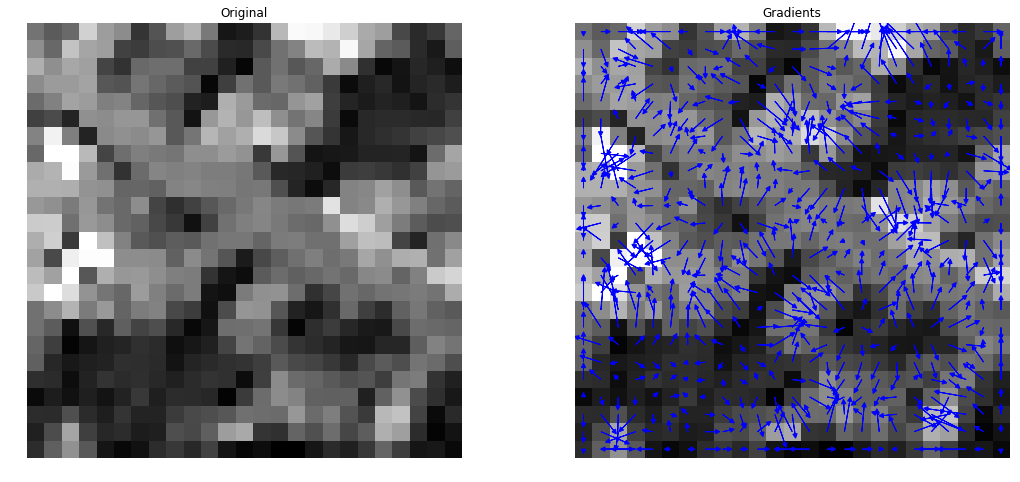

In [142]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(window, cmap=plt.cm.gray)
ax1.set_title('Original')
ax1.set_adjustable('box-forced')

ax2.axis('off')
ax2.imshow(window, cmap=plt.cm.gray)
ax2.set_title('Gradients')
ax2.set_adjustable('box-forced')
for i in range(angle.shape[0]):
    for j in range(angle.shape[1]):
        ax2.arrow(j, i, gx[i, j], gy[i, j], head_width=0.25, head_length=0.25, fc='b', ec='b')

plt.show()

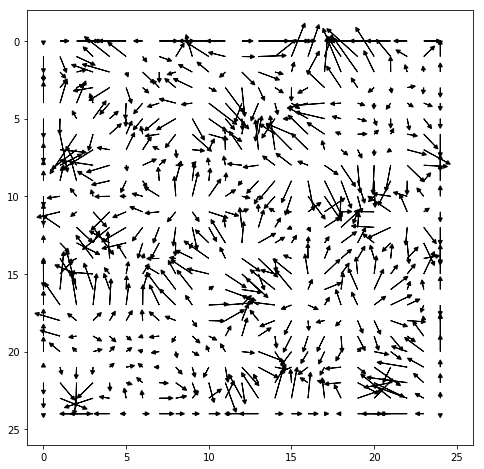

In [163]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_ylim([gx.shape[1]+1, -2])
ax.set_xlim([-1,gx.shape[0]+1])
ax.set_adjustable('box-forced')

for i in range(angle.shape[0]):
    for j in range(angle.shape[1]):
        ax.arrow(j, i, gx[i, j], gy[i, j], head_width=0.25, head_length=0.25,fc='k', ec='k')

plt.show()

In [27]:
print(window.shape)
print(angle.shape)

(25, 25)
(25, 25)


In [188]:
# My own binning algorithm. It does not do edge case detection because we're using the full 360 degrees the
# edge between 360 and 0 is there. I'm assuming no values over 360 exist.

def bin_orientations(angles, magnitudes, number_of_orientations):
    if len(angles.shape) > 2:
        print("Only 2d windows are supported")
        return

    if angles.shape != magnitudes.shape:
        print("Angle and magnitudes do not match shape:", angles.shape, magnitudes.shape)
        return

    number_of_orientations_per_360 = 360. / number_of_orientations
    x_size, y_size = angles.shape


    orientation_histogram = np.zeros(number_of_orientations)
    bin_centers = np.zeros(number_of_orientations)

    for i in range(number_of_orientations):
        orientation_end = number_of_orientations_per_360 * (i + 1)
        orientation_start = number_of_orientations_per_360 * i
        bin_centers[i] = (orientation_end + orientation_start) / 2.

        total = 0
        for x in range(x_size):
            for y in range(y_size):
                if angles[x, y] >= orientation_start and angles[x, y] < orientation_end:
                    total += magnitudes[x, y];

        orientation_histogram[i] = total
    return orientation_histogram, bin_centers
    
orientation_histogram, bin_centers = bin_orientations(angle, mag, 50)
print(orientation_histogram)


[ 21.58181811   2.77653285   8.71713333   8.42427458   6.81922183
  10.18682212  16.24189709  12.13626067   7.38080685  11.59936319
   7.32868356  13.26505746  24.48249419   6.13389244   3.44865597
   8.04604157  10.45918993   6.77021985   5.34382735   5.57618268
   6.51154096   3.97423305   5.88895144   7.9134767    5.70912945
  22.21947691  10.44329578  12.88586152   6.49287041  14.4869518
  17.53395271  13.53861889  17.2635346   12.20428114  10.74877145
   8.91643457  15.93501324  21.76167396  18.59746992  11.36852247
  11.53238555  10.19944553   5.3406737    8.86986271   7.09624676
   6.0490747    5.03732752   2.1242731    1.69509639   5.29410206]


<Container object of 50 artists>

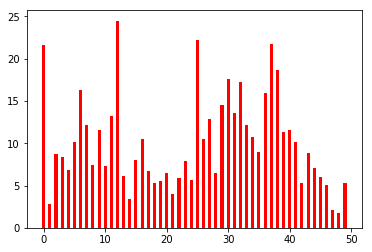

In [189]:
fig, ax = plt.subplots()

ind = np.arange(len(orientation_histogram))  # the x locations for the groups
width = 0.5       # the width of the bars

ax.bar(ind, orientation_histogram, width, color='r')

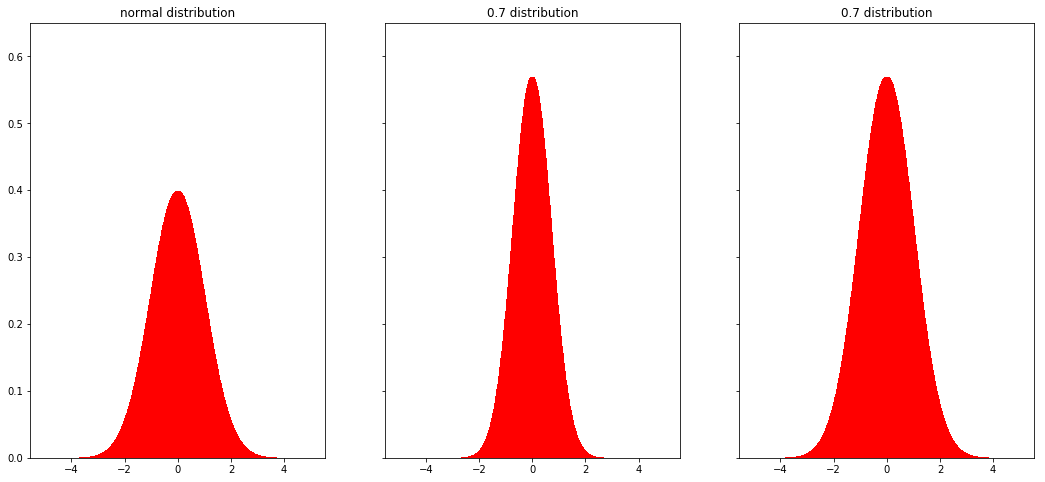

In [273]:
# Trying out gaussian kernels.

import scipy.stats

kernel1 = scipy.stats.norm(0, 1)
kernel2 = scipy.stats.norm(0, 0.7)

space = np.linspace(-5, 5.0, num=1000)

heights1 = kernel1.pdf(space)
heights2 = kernel2.pdf(space)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 8), sharex=True, sharey=True)

width = 0.1       # the width of the bars

ax1.set_ylim([0,0.65])
ax1.bar(space, heights1, width, color='r')
ax1.set_title('normal distribution')

ax2.set_ylim([0,0.65])
ax2.bar(space, heights2, width, color='r')
ax2.set_title('0.7 distribution')

ax3.set_ylim([0,0.65])
ax3.bar(space, heights1 / 0.7, width, color='r') # <--- This is the one from the paper
ax3.set_title('0.7 distribution')

In [265]:
def smoothe_histogram_np(histogram, kernel, bandwidth):
    """
    Vectorized smoothing implementation
    """
    if len(histogram.shape) > 1:
        print("Can only smooth a 1d array histogram")
        return
    
    bins = histogram.shape[0]

    # Make a bins x bins matrix with the inter-bin distances
    # Equivalent to:
    # for i in bins:
    #     for j in bins
    #         matrix[i, j] = (i - j) / bandwidth
    matrix = np.array([i - np.arange(bins) for i in np.arange(bins)]) / bandwidth
    smoothing_matrix = kernel(matrix)
    
    smoothing_factor_totals = np.sum(smoothing_matrix, axis = 1)
    pre_smooth_histogram = np.sum(smoothing_matrix * histogram, axis = 1)
    
    smoothed_histogram = pre_smooth_histogram / smoothing_factor_totals
    
    return smoothed_histogram

In [270]:
def smoothe_histogram(histogram, kernel, bandwidth):
    """
    Naive smoothing implementation
    """
    if len(histogram.shape) > 1:
        print("Can only smooth a 1d array histogram")
        return
    
    bins = histogram.shape[0]
    smoothed_histogram = np.zeros(bins)

    for i in range(bins):
        height = histogram[i]
        smoothing = 0
        smoothing_factor_total = 0
        for j in range(bins):
            smooth_factor = kernel((i - j) / bandwidth)
        
            smoothing += smooth_factor * histogram[j]
            smoothing_factor_total += smooth_factor
normalized_image = normalize_image(image, bands)
        smoothed_histogram[i] = smoothing / smoothing_factor_total

    return smoothed_histogram


kernel = scipy.stats.norm().pdf # Normal Gaussian Distribution
bandwidth = 0.7 # Value from the paper
smoothed_histogram = smoothe_histogram(orientation_histogram, kernel, bandwidth)
np_smooth = smoothe_histogram_np(orientation_histogram, kernel, bandwidth)

In [271]:
import time

kernel = scipy.stats.norm().pdf # Normal Gaussian Distribution

difference = 0
number = 10000
for i in range(number):
    t0 = time.clock()
    smoothe_histogram(orientation_histogram, kernel, 0.7)
    t1 = time.clock()

    difference += t1 - t0

difference *= 1000000
print("smoothe_histogram took on average", difference / number, "microseconds")

smoothe_histogram took on average 207736.82280000212 microseconds


In [274]:
import time

kernel = scipy.stats.norm().pdf # Normal Gaussian Distribution

difference = 0
number = 10000
for i in range(number):
    t0 = time.clock()
    smoothe_histogram_np(orientation_histogram, kernel, 0.7)
    t1 = time.clock()

    difference += t1 - t0

difference *= 1000000
print("smoothe_histogram_np took on average", difference / number, "microseconds")

smoothe_histogram_np took on average 411.42810000351346 microseconds


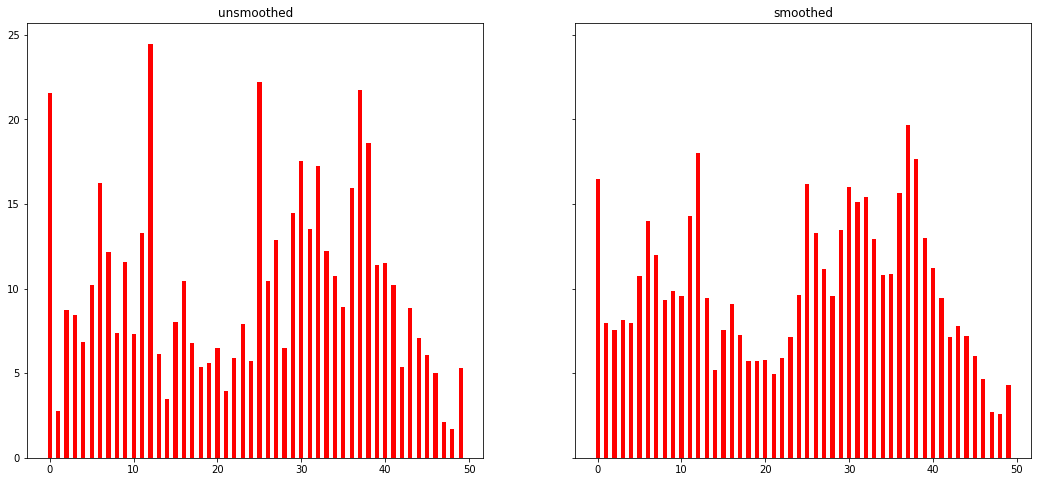

In [191]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8), sharex=True, sharey=True)

ind = np.arange(len(orientation_histogram))  # the x locations for the groups
width = 0.5       # the width of the bars

ax1.bar(ind, orientation_histogram, width, color='r')
ax1.set_title('unsmoothed')

ax2.bar(ind, smoothed_histogram, width, color='r')
ax2.set_title('smoothed')

In [224]:
diff = smoothed_histogram - v0

print(diff[diff>0])

[ 6.44007164  0.67825429  3.91616912  1.91615854  4.20212897  7.97847772
  6.11804784  3.21825209  1.11395203  3.38410533  5.9159493   5.05794517
  5.33643266  2.8641076   0.72260958  0.8285265   5.60331056  9.62805969
  7.60582421  2.91352169  1.17166517]


In [221]:
# Calculate the Heaved Central-shift Moments
# The first and second order are used as features

def heaved_central_shift_moment(histogram, order):
    if len(histogram.shape) > 1:
        print("Can only calculate moments on a 1d array histogram")
        return
    
    bins = histogram.shape[0]
    v0 = np.mean(histogram)
    
    # Moment 0 is just the mean
    if order == 0:
        return v0
    
    total = 0
    # In the paper they say: sum over all bins
    # The difference of the bin with the mean of the histogram (v0)
    # and multiply with a step function which is 1 when the difference is > 0
    diff = histogram - v0
    # The step function is thus a selection method, which is more easily written like this
    positive_diff = diff[diff > 0]
    
    power = order + 1
    numerator = np.sum(np.power(positive_diff, power))
    denominator = np.sum(positive_diff)
    
    v = numerator / denominator
    
    return v
    
v1 = heaved_central_shift_moment(smoothed_histogram, 1)
v2 = heaved_central_shift_moment(smoothed_histogram, 2)

print(v1, v2)

5.6921151085 37.7155916291


In [193]:
# Find the two highest peaks. This is used for the following three features
peaks = np.argsort(smoothed_histogram)[::-1][0:2]

In [197]:
# Feature 3 and 4: The absolute 'location' of the highest peak.
# We can only interpret this as either the bin number, or the orientation at the center of the bin
# That still doesn't give us 2 values, so we decided to take the center orientations of the bins of the
# two highest peaks in degrees

delta1 = bin_centers[peaks[0]]
delta2 = bin_centers[peaks[1]]

print(peaks)
print(delta1, delta2)

[   3.6   10.8   18.    25.2   32.4   39.6   46.8   54.    61.2   68.4
   75.6   82.8   90.    97.2  104.4  111.6  118.8  126.   133.2  140.4
  147.6  154.8  162.   169.2  176.4  183.6  190.8  198.   205.2  212.4
  219.6  226.8  234.   241.2  248.4  255.6  262.8  270.   277.2  284.4
  291.6  298.8  306.   313.2  320.4  327.6  334.8  342.   349.2  356.4]
[37 12]
270.0 90.0


In [195]:
# Feature 5: The absolute sine difference between the two highest peaks
# Will be 1 when the two peaks are 90 degrees from eachother
centers = np.deg2rad(bin_centers)
beta = np.abs(np.sin(centers[0] - centers[1]))

print(beta)

0.125333233564
